# Trabalho Prático 2: Realidade Aumentada
### André de Oliveira Godoy, 2018055130

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import OpenGL.GLU as glu
import OpenGL.GL as gl
import OpenGL.GLUT as glut
from objloader import *
import cv2
import time

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Passo 1: Calibração da câmera

Para a calibração da câmera, foi utilizada a ferramenta 'Camera Calibration Toolbox for Matlab', disponibilizada em http://www.vision.caltech.edu/bouguetj/calib_doc/. 

Frames aleatórios e não-contínuos do vídeo *entrada.mp4* foram extraídos e utilizados na ferramenta. A mesma obteve os seguintes resultados acerca dos parâmetros intrínsecos da câmera utilizada:

f = [813.91195, 814.61589]  
cc = [467.00698, 327.75643]

Com tais valores, é possível criar uma função que os utiliza para construir e retornar uma matriz de parâmetros intrìnsecos:

In [2]:
def gera_matriz_parametros_intrinsecos():
    matriz = np.identity(3, dtype=float)
    matriz[0, 0] = 813.91195
    matriz[1, 1] = 814.61589
    matriz[0, 2] = 320
    matriz[1, 2] = 240

    distorcao = [0.07356, -0.16064, -0.007, 0.00281, 0]

    return matriz, distorcao

gera_matriz_parametros_intrinsecos()

(array([[813.91195,   0.     , 320.     ],
        [  0.     , 814.61589, 240.     ],
        [  0.     ,   0.     ,   1.     ]]),
 [0.07356, -0.16064, -0.007, 0.00281, 0])

E, com a matriz em mãos, é possível ajustar os parâmetros intrìnsecos da câmera:

In [3]:
def ajuste_intrinsecos_camera(width, height, K):
    fx = K[0, 0]
    fy = K[1, 1]

    fovy = 2*np.arctan(0.5*height/fy) * 180/np.pi
    aspect = (width*fy)/(height*fx)

    near = 0.1
    far = 100.0

    glu.gluPerspective(fovy, aspect, near, far)

## Passo 2: Obtenção da posição e orientaçâo dos alvos

Primeiramente, o vídeo de entrada deve ser lido, obtendo-se cada frame que o compôe:

In [4]:
def captura_frames():
    cap = cv2.VideoCapture('entrada.mp4')
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if ret is True:
            frames.append(frame)
        else:
            break
    cap.release()
    return frames

frames = captura_frames()

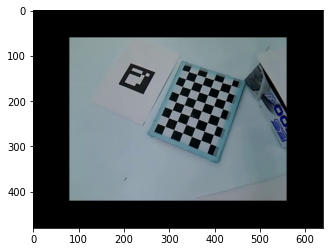

In [5]:
plt.imshow(frames[500]) # Exemplo de frame obtido
plt.show()

Entao, carrega-se o alvo a ser buscado, bem como possíveis rotações em que pode estar presente na cena.

In [6]:
def obtem_alvo():
    alvo = cv2.imread('alvo.jpg', 0)
    alvo_w, alvo_h = alvo.shape[::-1]

    # Array com coordenadas dos pixels de cada canto da imagem. Sera utilizado posteriormente
    cantos_alvo = np.array([(0, 0), (0.0, alvo_h), (alvo_w, alvo_h), (alvo_w, 0.0)], dtype=float)

    return alvo, cantos_alvo

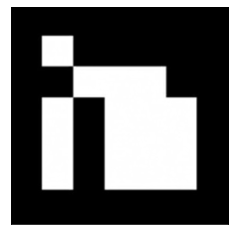

Dimensoes =  (304, 304)


In [7]:
alvo, cantos_alvo = obtem_alvo()

plt.imshow(alvo, cmap='gray'); plt.xticks([]); plt.yticks([])
plt.show()
print('Dimensoes = ', alvo.shape[::-1])

In [8]:
def gera_mapa_rotacoes_alvo(alvo):
    alvo_rot90 = cv2.rotate(alvo, cv2.ROTATE_90_CLOCKWISE)
    alvo_rot180 = cv2.rotate(alvo_rot90, cv2.ROTATE_90_CLOCKWISE)
    alvo_rot270 = cv2.rotate(alvo_rot180, cv2.ROTATE_90_CLOCKWISE)
    rotacoes_alvo = [alvo, alvo_rot90, alvo_rot180, alvo_rot270]

    # Evita guardar varias matrizes. Dicionário permite que se guarde apenas o grau de rotação
    mapa_rotacao = {} 
    mapa_rotacao[0] = alvo
    mapa_rotacao[90] = alvo_rot90
    mapa_rotacao[180] = alvo_rot180
    mapa_rotacao[270] = alvo_rot270
    
    # Coordenadas de mundo arbitrárias definidas para cada orientação possível
    p1 = [-1, -1, 0]; p2 = [1, -1, 0]; p3 = [1, 1, 0]; p4 = [-1, 1, 0]
    mapa_coordenada = {}
    mapa_coordenada[90] = np.float32([p1, p2, p3, p4])
    mapa_coordenada[0] = np.float32([p4, p1, p2, p3])
    mapa_coordenada[270] = np.float32([p3, p4, p1, p2])
    mapa_coordenada[180] = np.float32([p2, p3, p4, p1])
    

    return mapa_rotacao, mapa_coordenada

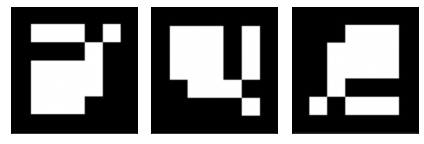

In [9]:
mapa_rotacao, mapa_coordenada = gera_mapa_rotacoes_alvo(alvo)

plt.subplot(1, 3, 1)
plt.imshow(mapa_rotacao[90], cmap='gray'); plt.xticks([]); plt.yticks([])
plt.subplot(1, 3, 2)
plt.imshow(mapa_rotacao[180], cmap='gray'); plt.xticks([]); plt.yticks([])
plt.subplot(1, 3, 3)
plt.imshow(mapa_rotacao[270], cmap='gray'); plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

Entao, cada frame do vídeo é processado, obtendo-se a posição e orientação de cada alvo - caso exista - frame a frame

In [10]:
def processa_frames(frames, alvo, mapa_rotacao):
    frame_processado = [] # Cada elemento é uma tripla (frame, posicao, orientacao)
    for frame in frames:

        # O frame passa a conter apenas tons de cinza, para facilitar binarização
        frame_cinza = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # A binarização facilita a extração de bordas
        _, frame_binarizado = cv2.threshold(frame_cinza, 127, 255, cv2.THRESH_BINARY)
    
        # Por sua vez, a extração das bordas facilita a procura por contornos na cena
        frame_bordas = cv2.Canny(frame_binarizado, 60, 100)

        contornos, _ = cv2.findContours(frame_bordas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Aproxima um poligono em cada contorno obtido. Caso tal polígono possua quatro lados e seja
        # convexo, então o mesmo é classificado como quadrilatero - que é a mesma classificação dos alvos
        # procurados.
        lista_quadrilateros = []
        for contorno in contornos:
            poligono_aproximado = cv2.approxPolyDP(contorno, 0.02 * cv2.arcLength(contorno, True), True)
            if len(poligono_aproximado) == 4 and cv2.isContourConvex(poligono_aproximado):
                lista_quadrilateros.append(poligono_aproximado)
    
        poses_na_cena = []
        for quadrilatero in lista_quadrilateros:
            # Obtem-se a homografia do contorno do possível alvo para o alvo original. Ela é então utilizada
            # para mudar a perspectiva do trecho da imagem, possibilitando que este candidato, em uma nova perspectiva
            # seja comparado ao alvo original.
            homografia, _ = cv2.findHomography(np.float32(quadrilatero), cantos_alvo, cv2.RANSAC)
            nova_perspectiva = cv2.warpPerspective(frame_cinza, homografia, alvo.shape[::-1])

            # Binarização do candidato, pois o mesmo é comparado a um alvo em preto e branco
            _, nova_perspectiva_binarizada = cv2.threshold(nova_perspectiva, 80, 255, cv2.THRESH_BINARY)

            menor_erro_comparacao = np.inf
            melhor_rotacao_encontrada = None

            for rotacao in mapa_rotacao.values():
                erro_comparacao = np.sum(np.abs(nova_perspectiva_binarizada - rotacao)) / nova_perspectiva_binarizada.size
                if erro_comparacao < menor_erro_comparacao:
                    menor_erro_comparacao = erro_comparacao
                    if (rotacao == alvo).all():
                        melhor_rotacao_encontrada = 0
                    elif (rotacao == mapa_rotacao[90]).all():
                        melhor_rotacao_encontrada = 90
                    elif (rotacao == mapa_rotacao[180]).all():
                        melhor_rotacao_encontrada = 180
                    elif (rotacao == mapa_rotacao[270]).all():
                        melhor_rotacao_encontrada = 270
                    else:
                        melhor_rotacao_encontrada = -1

            # Define-se como 'match' os candidatos que obtiveram erro menor do que 20
            if menor_erro_comparacao < 20:
                poses_na_cena.append((quadrilatero, melhor_rotacao_encontrada))

        frame_processado.append(poses_na_cena)

    return frame_processado

Demonstração dos matches encontrados:

Algumas posições encontradas:

## Parte 3: Ajuste parâmetros extrínsecos

Para obtenção da pose, será utilizada a função solvePnP:

In [11]:
def obtem_pose(posicao, orientacao):
    coordenada_arbitraria = mapa_coordenada[orientacao]
    matriz_parametros_intrinsecos, distorcao = gera_matriz_parametros_intrinsecos()

    _, rvec, tvec = cv2.solvePnP(coordenada_arbitraria, np.float32(posicao), matriz_parametros_intrinsecos, np.float32(distorcao))

    matriz_rotacao, _ = cv2.Rodrigues(rvec)
    matriz_pose = np.append(matriz_rotacao, tvec, axis=1)
    matriz_pose = np.append(matriz_pose, [[0, 0, 0, 1]], axis = 0)

#   
    matriz_pose[1, 0] *= -1
    matriz_pose[2, 0] *= -1 
##
    matriz_pose[1, 1] *= -1
    matriz_pose[2, 1] *= -1
    ###
    matriz_pose[1, 2] *= -1
    matriz_pose[2, 2] *= -1
    ###
    matriz_pose[1, 3] *= -1
    matriz_pose[2, 3] *= -1
    
    return np.transpose(matriz_pose)


## Parte 4: Renderização

In [12]:
def initOpenGL(dimensions):
    width, height = dimensions

    gl.glClearColor(0.0, 0.0, 0.0, 0.0)
    gl.glClearDepth(1.0)

    gl.glEnable(gl.GL_DEPTH_TEST)

    gl.glMatrixMode(gl.GL_PROJECTION)
    gl.glLoadIdentity()
    
    K, _ = gera_matriz_parametros_intrinsecos()
    ajuste_intrinsecos_camera(width, height, K)

In [13]:
def resize_view(width, height, K):
    gl.glViewport(0, 0, width, height)

    gl.glMatrixMode(gl.GL_PROJECTION)
    gl.glLoadIdentity()
    ajuste_intrinsecos_camera(width, height, K)

    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    glu.gluLookAt(0, 0, 5, 0, 0, 0, 0, 1, 0)

In [14]:
def background(img):
    id_textura = gl.glGenTextures(1)
    gl.glBindTexture(gl.GL_TEXTURE_2D, id_textura)

    fundo = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #fundo = cv2.flip(fundo, 0)
    
    gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MAG_FILTER, gl.GL_LINEAR)
    gl.glTexParameteri(gl.GL_TEXTURE_2D, gl.GL_TEXTURE_MIN_FILTER, gl.GL_LINEAR)
    gl.glTexImage2D(gl.GL_TEXTURE_2D, 0, gl.GL_RGB, 640, 480, 0, gl.GL_RGB, gl.GL_UNSIGNED_BYTE, fundo)

    gl.glDepthMask(gl.GL_FALSE)
    gl.glDisable( gl.GL_DEPTH_TEST )

    gl.glMatrixMode(gl.GL_PROJECTION)
    gl.glLoadIdentity()
    gl.glOrtho(0, 640, 480, 0.0, 0.0, 1)
    
    gl.glEnable( gl.GL_TEXTURE_2D )
    gl.glBegin(gl.GL_QUADS)
    gl.glTexCoord2f(0, 0); gl.glVertex2f(0, 0)
    gl.glTexCoord2f(1, 0); gl.glVertex2f(640, 0)
    gl.glTexCoord2f(1, 1); gl.glVertex2f(640, 480)
    gl.glTexCoord2f(0, 1); gl.glVertex2f(0, 480)
    gl.glEnd()

    gl.glBindTexture(gl.GL_TEXTURE_2D, 0)
    gl.glEnable( gl.GL_DEPTH_TEST )
    gl.glDepthMask(gl.GL_TRUE)

    gl.glFlush()
    

In [15]:
def desenha_pikachus_nas_posicoes(obj, infos_cena_atual):
    for posicao, orientacao in infos_cena_atual:   
        m = obtem_pose(posicao, orientacao)
        gl.glLoadMatrixf(m)
        gl.glCallList(obj.gl_list)

In [16]:
def cria_e_posiciona_cubo(m):

    vertices = (
        (1, -1, -1), (1, 1, -1), (-1, 1, -1),
        (-1, -1, -1),(1, -1, 1), (1, 1, 1),
        (-1, -1, 1), (-1, 1, 1)
    )

    arestas = (
        (2,1), (0,1), (0,3),
        (0,4), (2,3), (2,7),
        (6,3), (6,4), (6,7),
        (5,1), (5,4), (5,7)
    )
    
    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    gl.glLoadMatrixf(m)

    gl.glPushAttrib(gl.GL_CURRENT_BIT)
    gl.glLineWidth(4)

    gl.glBegin(gl.GL_LINES)
    gl.glColor3f(124/255, 252/255, 0)
    first_seg = True
    for aresta in arestas:
        for vertice in aresta:
            gl.glVertex3fv(vertices[vertice])
            if first_seg:
                first_seg = False
                gl.glColor3f(124/255, 252/255, 0)
            else:
                gl.glColor3f(230/255, 0., 126/255)
    gl.glEnd()

    gl.glMatrixMode(gl.GL_PROJECTION)
    gl.glLoadIdentity()
    gl.glPopAttrib()
    gl.glFlush()

In [17]:
def desenha_cubos_nas_posicoes(infos_cena_atual):
    for posicao, orientacao in infos_cena_atual:   
        m = obtem_pose(posicao, orientacao)
        cria_e_posiciona_cubo(m)

In [18]:
def renderiza_pikachus(infos_cena_atual, modelo_objeto):    
    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    gl.glEnable(gl.GL_TEXTURE_2D)

    desenha_pikachus_nas_posicoes(modelo_objeto, infos_cena_atual)

In [19]:
def renderiza_cubos(infos_cena_atual):    
    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    gl.glEnable(gl.GL_TEXTURE_2D)

    desenha_cubos_nas_posicoes(infos_cena_atual)

In [20]:
def cria_cena(frames, frames_processados, modelo_pikachu):
    global frame_index
    global render_cubo
    global render_pikachu

    if frame_index >= len(frames_processados) and not render_pikachu:
        render_pikachu = True
        render_cubo = False
        frame_index = 0

    elif frame_index >= len(frames_processados) and render_pikachu:
        return

    gl.glMatrixMode(gl.GL_MODELVIEW)
    gl.glLoadIdentity()
    gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)

    infos_cena_atual = frames_processados[frame_index]

    background(frames[frame_index])
    gl.glMatrixMode(gl.GL_PROJECTION)
    gl.glLoadIdentity() 
    K, _ = gera_matriz_parametros_intrinsecos()
    ajuste_intrinsecos_camera(640, 480, K)

    if render_pikachu:
        renderiza_pikachus(infos_cena_atual, modelo_pikachu)
    else:
        renderiza_cubos(infos_cena_atual)

    glut.glutSwapBuffers()

    time.sleep(1/18) # Valor qualquer pro vídeo nao ficar muito rapido
    frame_index = frame_index + 1

In [21]:
def idleCallback():
    glut.glutPostRedisplay()

Lógica para renderização do Pikachu:

In [22]:
def realidade_aumentada_pikachu(frames, frames_processados):
    dimensoes_frame = (640, 480)

    K, _ = gera_matriz_parametros_intrinsecos()

    glut.glutInit()
    glut.glutInitDisplayMode(glut.GLUT_RGBA | glut.GLUT_DOUBLE)
    glut.glutSetOption(glut.GLUT_ACTION_ON_WINDOW_CLOSE, glut.GLUT_ACTION_CONTINUE_EXECUTION)
    glut.glutInitWindowSize(*dimensoes_frame)
    janela = glut.glutCreateWindow(b'Realidade Aumentada - Pikachu')
    
    initOpenGL(dimensoes_frame)

    global frame_index
    frame_index = 0

    global render_pikachu
    render_pikachu = False

    global render_cubo
    render_cubo = True

    obj = OBJ("Pikachu.obj", swapyz=True)
    
    display_callback = lambda: cria_cena(frames, frames_processados, obj)
    reshape_callback = lambda w, h: resize_view(w, h, K)

    glut.glutDisplayFunc(display_callback)
    glut.glutReshapeFunc(reshape_callback)
    glut.glutIdleFunc(idleCallback)
    glut.glutMainLoop()

In [2]:
alvo, cantos_alvo = obtem_alvo()
frames = captura_frames()
mapa_rotacao, mapa_coordenada = gera_mapa_rotacoes_alvo(alvo)
frames_processados = processa_frames(frames, alvo, mapa_rotacao)

NameError: name 'obtem_alvo' is not defined

In [24]:
realidade_aumentada_pikachu(frames, frames_processados)

In [25]:
alvo, cantos_alvo = obtem_alvo()
frames = captura_frames()
mapa_rotacao, mapa_coordenada = gera_mapa_rotacoes_alvo(alvo)
frames_processados = processa_frames(frames, alvo, mapa_rotacao)